# Kriss Sitapara - CS370 Assignment 2A

ResNet18 is a CNN that has already been trained on the ImageNet dataset. I used the pretrained=True option to make sure I’m getting a version of the model that’s already trained, so I don’t have to train it from scratch. Then, I set the model to evaluation mode using model.eval(), which tells the model that I’m just testing it and not training it further.

In [75]:
import torch
from torchvision import models

model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [76]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

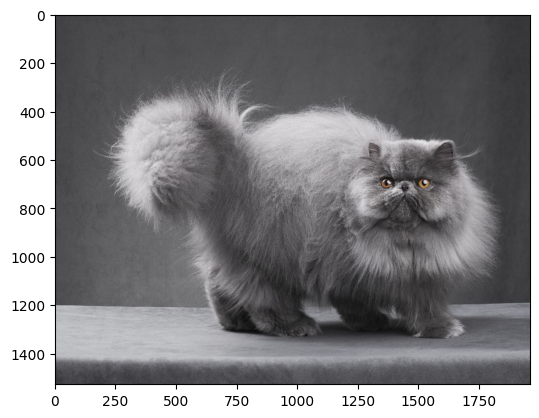

In [77]:
img_path = "datapic/cat2.jpg"
image = Image.open(img_path)
plt.imshow(image)
plt.show()

In [78]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [79]:
input_tensor = preprocess(image)
input_tensor = input_tensor.unsqueeze(0)
print(f"Tensor Shape: {input_tensor.shape}")
print(f"Tensor Values (Range): {input_tensor.min()} to {input_tensor.max()}")

Tensor Shape: torch.Size([1, 3, 224, 224])
Tensor Values (Range): -1.8610327243804932 to 2.1345534324645996


In Cells 7-15, I loaded an image as done in the video. I then opened the image using the PIL.image and displayed it. Next I went on to apply the transformations in which I resized the image 224x224 pixels to match the input size expected by the ResNet model. I cropped out the part that wasn't needed. After that I converted into a PyTorch tensor. I simply then displayed the results

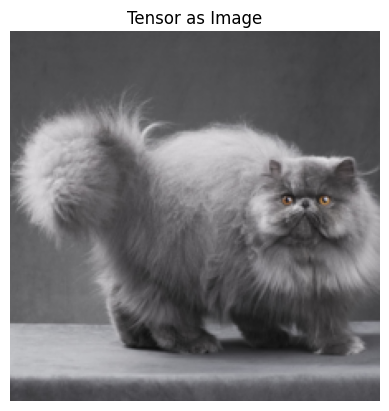

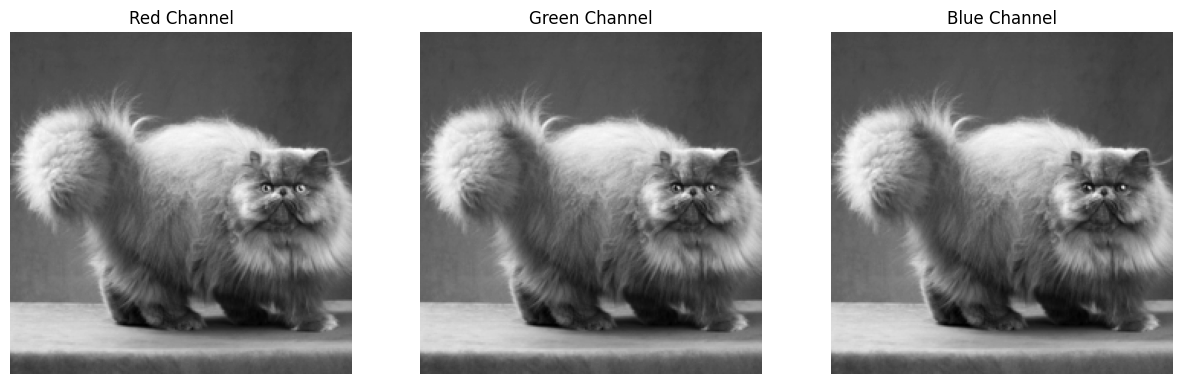

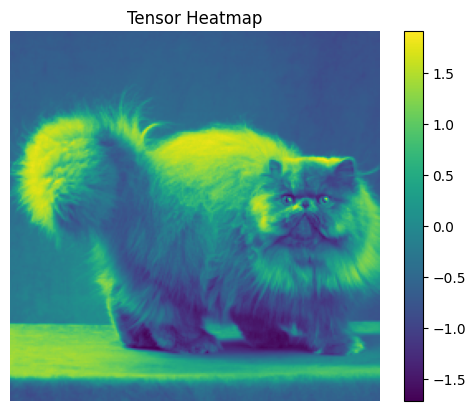

In [80]:
import numpy as np
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    tensor = tensor * std + mean
    return tensor
denormalized_tensor = denormalize(input_tensor[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
image_np = denormalized_tensor.permute(1, 2, 0).cpu().numpy()
image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.title("Tensor as Image")
plt.axis('off')
plt.show()

channels = ['Red', 'Green', 'Blue']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(input_tensor[0, i, :, :].cpu(), cmap='gray')
    ax.set_title(f"{channels[i]} Channel")
    ax.axis('off')

plt.show()
heatmap = input_tensor[0].mean(0).cpu().numpy()

plt.imshow(heatmap, cmap='viridis')
plt.title("Tensor Heatmap")
plt.colorbar()
plt.axis('off')
plt.show()

In the above cell, I visualized the image tensor to better understand its structure and how the preprocessing affects the data. It was so that I see what can potentially go on. I first denormalized the tensor I converted it back to a format suitable for visualization and displayed it as an image. I then also applied RGB channel to see what would stick out more. It helped me see how image data is represented in the model. I then made a heatmap to highlight the overall intensity distribution of the image.


In [81]:
output = model(input_tensor)
_, predicted_class = torch.max(output, 1)
print(f"Predicted class index: {predicted_class.item()}")

Predicted class index: 283


In [82]:
import json
import urllib.request
import torch.nn.functional as F
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
with urllib.request.urlopen(url) as response:
    class_idx = [line.strip() for line in response.readlines()]
predicted_label = class_idx[predicted_class.item()]
predicted_label = class_idx[predicted_class.item()].decode("utf-8")
print(f"Predicted label: {predicted_label}")
probabilities = F.softmax(output, dim=1)
predicted_prob = probabilities[0, predicted_class].item()
print(f"Predicted probability: {predicted_prob:.4f}")


Predicted label: Persian cat
Predicted probability: 0.9986


Here, I processed image tensor through the model to predict the class of the image. I used the model which gave me the logits for all possible classes in the ImageNet dataset. From the PyTorch repository, I downloaded a file containing the labels for all ImageNet classes. Each label corresponds to a specific class index. I then went on to get what class it was and in this case it was a Tabby which is correct. I actually even tried another cat (Persian Cat) and when I tried, it worked well for that as well and gave me the right output.

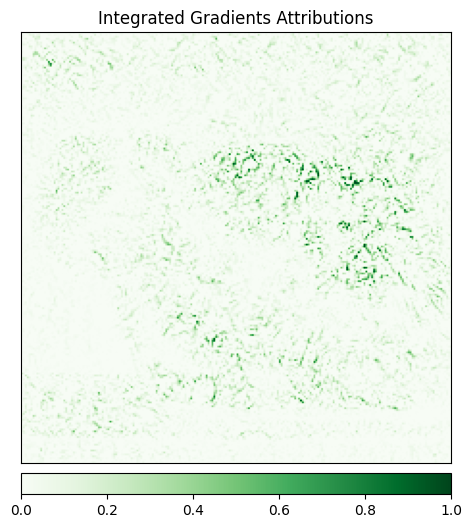

In [83]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

integrated_gradients = IntegratedGradients(model)
attributions = integrated_gradients.attribute(input_tensor, target=predicted_class, n_steps=200)

_ = viz.visualize_image_attr(
    attributions[0].detach().cpu().numpy().transpose(1, 2, 0),
    input_tensor[0].detach().cpu().numpy().transpose(1, 2, 0),
    method="heat_map",
    sign="positive",
    show_colorbar=True,
    title="Integrated Gradients Attributions"
)


I used the Integrated Gradients method to explain the model's prediction. I created an instance of IntegratedGradients from the captum.attr library, passing the pre-trained model as an argument. Using the attribute method, I computed the attributions for the input image. After this I overlaid the attributions as a heatmap on top of the input image. This highlighted the regions of the image that the model found most significant for its prediction. And surprisingly, you can almost see the face of the cat as well!

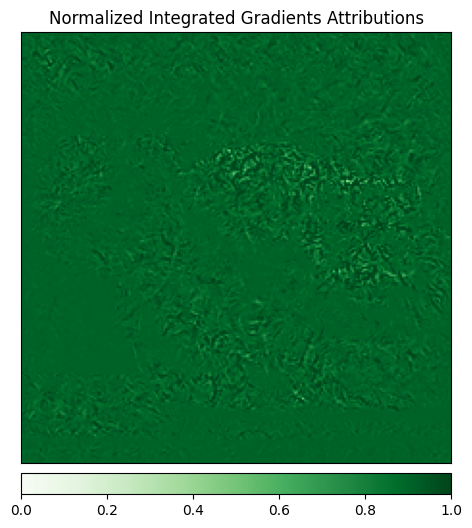

In [84]:
attributions_np = attributions[0].detach().cpu().numpy()
attributions_norm = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())
_ = viz.visualize_image_attr(
    attributions_norm.transpose(1, 2, 0),
    input_tensor[0].detach().cpu().numpy().transpose(1, 2, 0),
    method="heat_map",
    sign="positive",
    show_colorbar=True,
    title="Normalized Integrated Gradients Attributions"
)


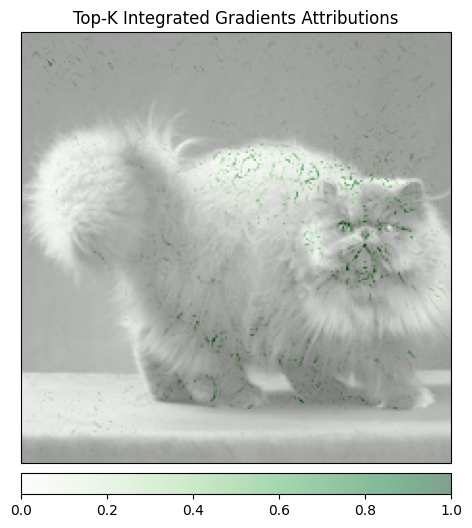

In [85]:
threshold = np.percentile(attributions_np, 90)
attributions_topk = np.where(attributions_np >= threshold, attributions_np, 0)
_ = viz.visualize_image_attr(
    attributions_topk.transpose(1, 2, 0),
    input_tensor[0].detach().cpu().numpy().transpose(1, 2, 0),
    method="blended_heat_map",
    sign="positive",
    show_colorbar=True,
    title="Top-K Integrated Gradients Attributions"
)
